
# LAB: **IMAGE SEGMENTATION**



---

***STUDENT(S):*** 

---


**Image segmentation** is a method in which a digital image is broken down into various subgroups called *Image segments* which helps in reducing the complexity of the image to make further processing or analysis of the image simpler. **Segmentation in easy words is assigning labels to pixels.** All picture elements or pixels belonging to the same category have a common label assigned to them. **For example**: Let’s take a problem where the picture has to be provided as input for object detection. Rather than processing the whole image, the detector can be inputted with a region selected by a segmentation algorithm. This will prevent the detector from processing the whole image thereby reducing inference time.
<figure>
<center><img src="https://vladlen.info/wp-content/uploads/FSO-1.jpg" width="60%"></center> 
<figcaption align = "center"> Image segmentation example. </figcaption>
</figure>


# Approaches in Image Segmentation

*   *Similarity approach*: This approach is based on detecting similarity between image pixels to form a segment, based on a threshold. ML algorithms like clustering are based on this type of approach to segment an image.
*   *Discontinuity approach*: This approach relies on the discontinuity of pixel intensity values of the image. Line, Point, and Edge Detection techniques use this type of approach for obtaining intermediate segmentation results which can be later processed to obtain the final segmented image.

# Image Segmentation Techniques

*   Threshold Based Segmentation
*   Edge Based Segmentation
*   Region-Based Segmentation
*   Clustering Based Segmentation
*   **Artificial Neural Network Based Segmentation**

In this lab we will focus on **Artificial Neural Network Based Segmentation** using **U-Net architecture**.

# U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other **semantic segmentation tasks**.

U-Net builds on a previous architecture called the **Fully Convolutional Network (FCN)** which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that **the input size no longer needs to be fixed**, as it does when dense layers are used.

Unfortunately, **the final feature layer of the FCN suffers from information loss due to downsampling too much**. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

<figure>
<center><img src="https://miro.medium.com/max/640/1*NXNGhfSyzQcKzoOSt-Z0Ng.webp" width="60%"></center> 
<figcaption align = "center"> FCN architecture. </figcaption>
</figure>


**U-Net improves on the FCN**. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds **skip connections**, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

<figure>
<center><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="70%"></center> 
<figcaption align = "center"> U-Net architecture. </figcaption>
</figure>






# Dataset

In this lab we will use [**Cityscapes**](https://www.cityscapes-dataset.com/) **Image Pairs dataset**. It contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.



# Imports


In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

ModuleNotFoundError: No module named 'torchvision'

# PART I: Loading Cityscapes dataset

First, import to your own Drive the folder I shared with you in Aula Global.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# UPDATE THIS ACCORDING TO YOUR PATH!
path_to_folder = '/content/drive/My Drive/Colab Notebooks/Lab_Img_Segmentation/Cityscapes/cityscapes_data/'

train_dir = os.path.join(path_to_folder, "train") 
test_dir = os.path.join(path_to_folder, "val")

train_fns = os.listdir(train_dir)
test_fns = os.listdir(test_dir)

print('We have %d train images.' %len(train_fns))
print('We have %d test images.' %len(test_fns))


We have 2975 train images.
We have 500 test images.


Visualize one image from Cityscapes

/content/drive/My Drive/Colab Notebooks/Lab_Img_Segmentation/Cityscapes/cityscapes_data/train/2620.jpg


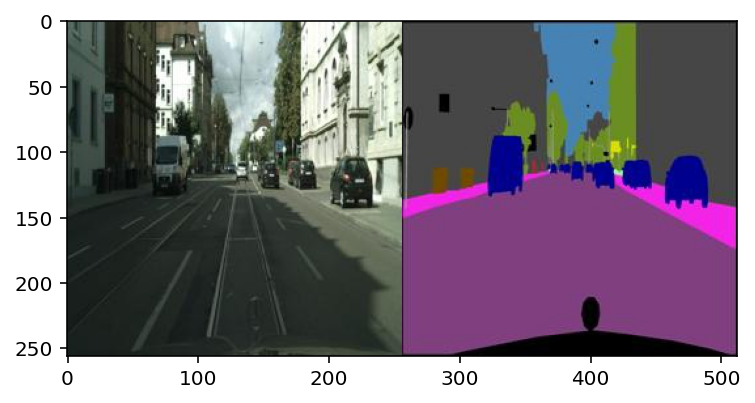

In [4]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

# PART II: Extracting Image and Labels
The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [5]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

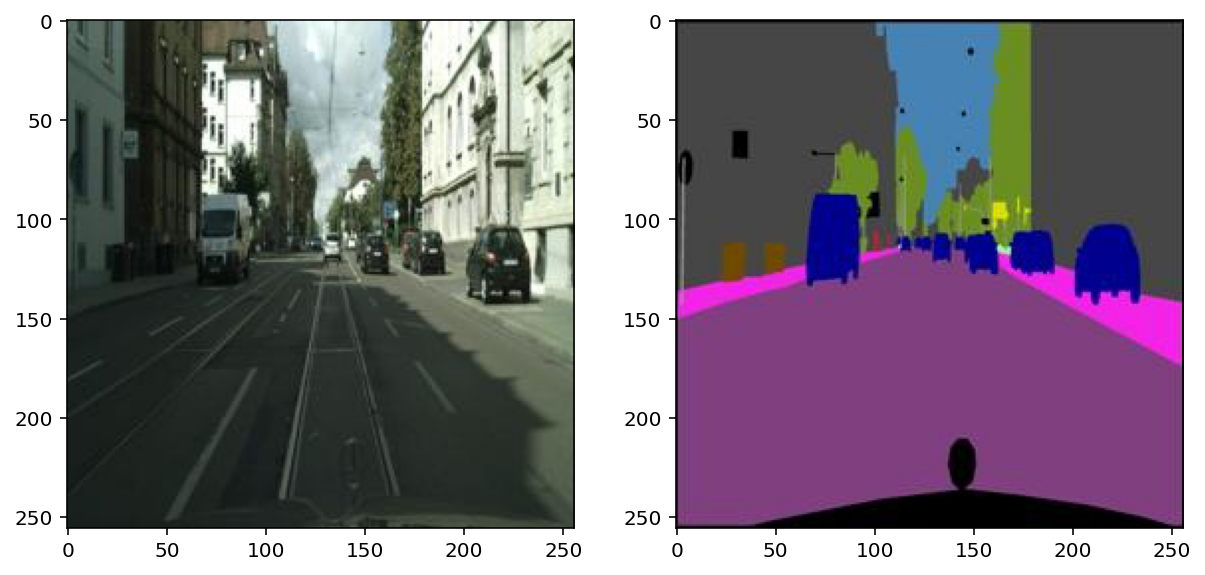

In [6]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

We need to transform the RGB label image (3 channels) to a label matrix (1 channel). For this, we have two options:

1.   Define a dictionary that maps RGB values to class labels.
2.   Train a clustering model (as K-Means) to assign class labels to RGB values automatically.


Let's try the second option to spice up things a little!

In [7]:
# Define random RGB images
num_items = 5000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(5000, 3)


In [8]:
# Learn how to cluster all the colors in num_classes
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

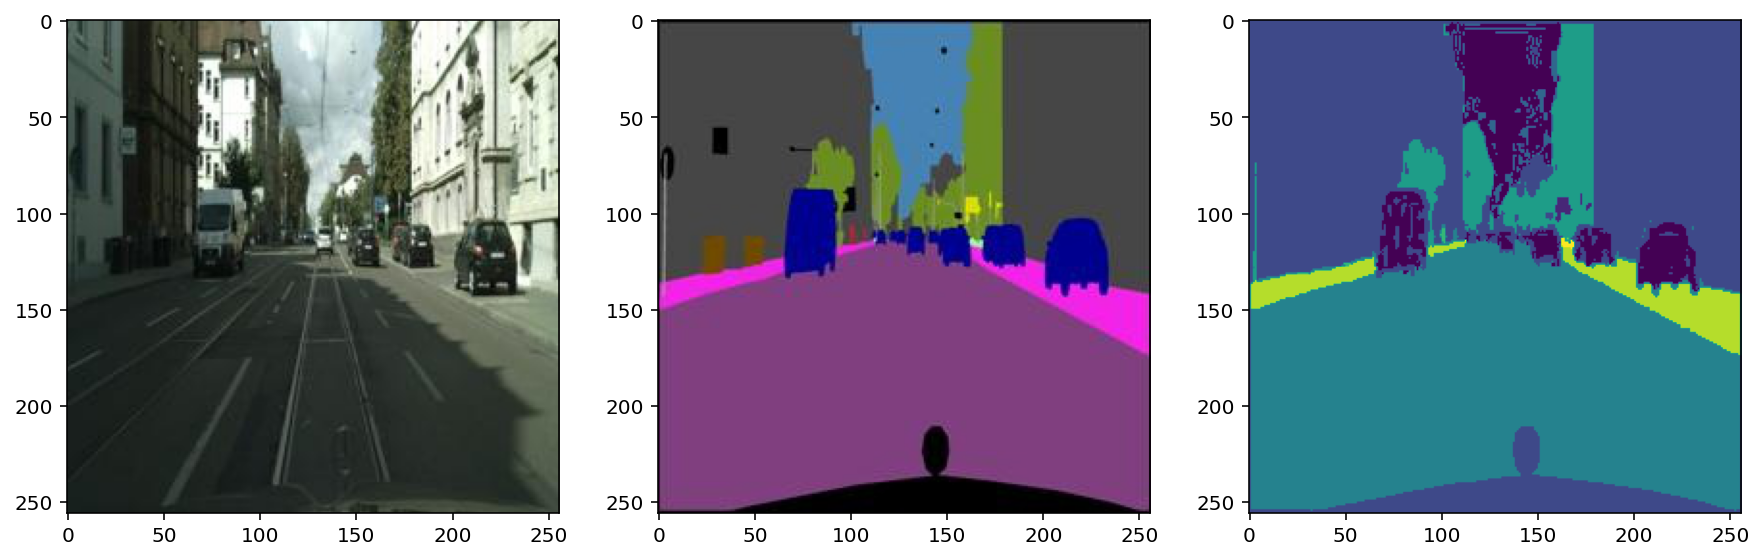

In [9]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

Now we define a Dataset for this data. In the transformations we reduce the size of the images to speed up training.

In [10]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):

    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):

    # Get the image from the root directory
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)

    # Split in image and labels
    cityscape, label = self.split_image(image)

    # Extract and transform label matrix
    label = np.array(self.transform_lab(Image.fromarray(label)))
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(64,64)
    label_class = torch.Tensor(label_class).long()

    # Transform image
    cityscape = self.transform_img(Image.fromarray(cityscape))

    return cityscape, label_class

  def split_image(self, image):

    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]

    return cityscape, label
  
  def transform_img(self, image):

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((64, 64)),
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform_ops(image)

  def transform_lab(self, image):

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((64, 64))
    ])

    return transform_ops(image)

In [11]:
dataset_train = CityscapeDataset(train_dir, label_model)
print(len(dataset_train))

dataset_test = CityscapeDataset(test_dir, label_model)
print(len(dataset_test))

2975
500


Let's show an example from our defined dataset. We define a method to visualize the images, as they are normalized.

In [12]:
def img_show(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([3, 64, 64])


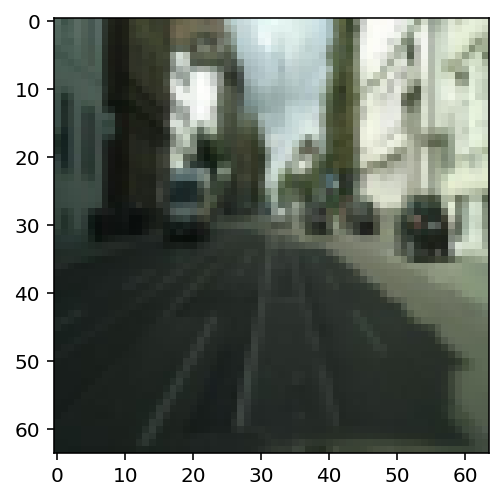

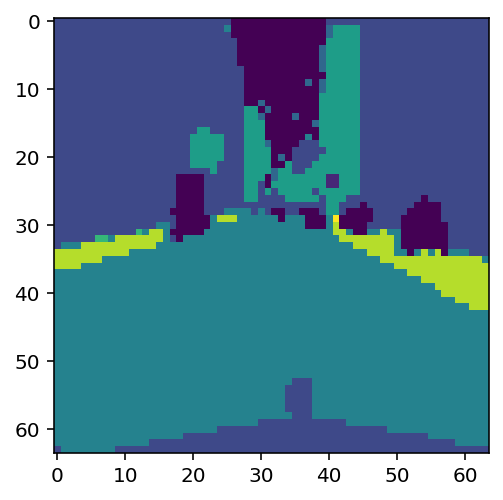

In [13]:
img, label_class = dataset_train[0]

print(img.shape)

img_show(img)

plt.imshow(label_class)
plt.show()

One we have defined the Dataset, we can define train and test dataloaders!

In [14]:
batch_size = 32
valid_size = 500

# Training partition
part_tr = torch.utils.data.random_split(dataset_train, [len(dataset_train)-valid_size, valid_size])[0]
# Use sampler for randomization
training_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_tr)))
# Define the dataloader
trainloader = torch.utils.data.DataLoader(part_tr, batch_size=batch_size, sampler=training_sampler)

# Validation partition
part_val = torch.utils.data.random_split(dataset_train, [valid_size, len(dataset_train)-valid_size])[0]
# Use sampler for randomization
valid_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_val)))
# Define the dataloader
validloader = torch.utils.data.DataLoader(part_val, batch_size=batch_size, sampler=valid_sampler)

# Test partition
# Use sampler for randomization
test_sampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_test)))
# Define the dataloader
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, sampler=test_sampler)


In [15]:
print('TRAIN: ', len(part_tr))
print('VALIDATION: ', len(part_val))
print('TEST: ', len(dataset_test))


TRAIN:  2475
VALIDATION:  500
TEST:  500


# PART III: Define the model

In this lab we are reproducing the following architecture, but for color images (we have a 3 channel image as input).

<figure>
<center><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="70%"></center> 
<figcaption align = "center"> U-Net architecture. </figcaption>
</figure>


This architecture has 4 main blocks:

*   **Encoder**: The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3×3 convolutions, each followed by a rectified linear unit (ReLU) and a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.
*   **Bottleneck**: Mid layer that passes the compressed information from the encoder to the decoder.
*   **Decoder**: Every step in the expansive path consists of an upsampling of the feature map followed by a 2×2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3×3 convolutions, each followed by a ReLU.
*   **Classifier**: Final convolution layer that outputs the segmented image.

The original U-Net does not use batch normalization in between the convolution layer and ReLU. Here we insert batch normalization in between them. It helps the network to reduce internal covariance shift and makes the network more stable while training.



# Basic blocks
First we implement the basic blocks for this architecture. The first one is the **convolutional block**, which consists of two 3x3 convolutional layers, each one followed by batch normalization and ReLU activation.


In [16]:
# === CONVOLUTIONAL BLOCK === #
# Two 3x3 convolutional layers, each followed by a batch 
# normalization and a ReLU activation.

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

Now we define the **encoder block**, which consists of a convolutional block followed by a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. 

Note that this block should return the output before and after the downsampling, so we can esily implement the skip connections in the full architecture.

In [17]:
# === ENCODER BLOCK === #
# It consists of an conv_block followed by a max pooling.
# Here the number of filters doubles and the height and width half after every block.

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

The last basic block we need to implement is the decoder block, which consists of a a 2×2 transpose convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path (**skip connections!**), and a convolutional block.

In [18]:
# === DECODER BLOCK === #
# The decoder block begins with a transpose convolution, followed by a concatenation with the skip
# connection from the encoder block. Next comes the conv_block.
# Here the number filters decreases by half and the height and width doubles.

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

# Full architecture

Now that we have implemented all the basic blocks, we can build our **full U-Net architecture**!

In [19]:
# === FULL ARCHITECTURE === #

class UNet(nn.Module):
    def __init__(self, n_labels):
        super().__init__()

        # ENCODER #
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # BOTTLENECK #
        self.b = conv_block(512, 1024)

        # DECODER #
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # CLASSIFIER #
        self.outputs = nn.Conv2d(64, n_labels, kernel_size=1, padding=0)

    def forward(self, inputs):

        # NOTATION:
        # s -> skip
        # p -> pooling

        # ENCODER #
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # BOTTLENECK #
        b = self.b(p4)

        # DECODER #
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        # CLASSIFIER #
        outputs = self.outputs(d4)

        return outputs

The following class completes the implementation of the U-Net, extending it with a training method.

In [20]:
class UNet_extended(UNet):

    def __init__(self, n_labels, lr=1e-3,epochs=20):
        
        super().__init__(n_labels)

        # TRAINING VARIABLES
        self.lr = lr    
        self.optim = optim.Adam(self.parameters(), self.lr)   
        self.epochs = epochs

        # CRITERION
        self.criterion = nn.CrossEntropyLoss()

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):

          running_loss = 0.

          for images, labels in trainloader:

            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optim.zero_grad()

            pred = self.forward(images)

            loss = self.criterion(pred, labels)

            loss.backward()

            self.optim.step()

            running_loss += loss.item()

          self.loss_during_training.append(running_loss/len(trainloader))

          # Validation
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():            
              
              running_loss = 0.
              
              for images,labels in validloader:

                  images = images.to(self.device)
                  labels = labels.to(self.device)
                  
                  pred = self.forward(images)

                  loss = self.criterion(pred,labels)

                  running_loss += loss.item()   
                  
              self.valid_loss_during_training.append(running_loss/len(validloader))

          print('\nTrain Epoch: {} -> Training Loss: {:.6f}'.format(e,self.loss_during_training[-1]))
          print('Train Epoch: {} -> Validation Loss: {:.6f}'.format(e,self.valid_loss_during_training[-1]))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.forward(images)

                labels_pred = torch.argmax(probs, dim=1)
                equals = (labels_pred == labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [21]:
n_epochs = 30
my_unet = UNet_extended(n_labels=10, lr=1e-3, epochs=n_epochs)
my_unet.trainloop(trainloader, validloader)



Train Epoch: 0 -> Training Loss: 1.003153
Train Epoch: 0 -> Validation Loss: 0.736999

Train Epoch: 1 -> Training Loss: 0.656187
Train Epoch: 1 -> Validation Loss: 0.632353

Train Epoch: 2 -> Training Loss: 0.589385
Train Epoch: 2 -> Validation Loss: 0.581082

Train Epoch: 3 -> Training Loss: 0.541915
Train Epoch: 3 -> Validation Loss: 0.547448

Train Epoch: 4 -> Training Loss: 0.517816
Train Epoch: 4 -> Validation Loss: 0.537309

Train Epoch: 5 -> Training Loss: 0.495626
Train Epoch: 5 -> Validation Loss: 0.492064

Train Epoch: 6 -> Training Loss: 0.474698
Train Epoch: 6 -> Validation Loss: 0.471734

Train Epoch: 7 -> Training Loss: 0.458461
Train Epoch: 7 -> Validation Loss: 0.468170

Train Epoch: 8 -> Training Loss: 0.440874
Train Epoch: 8 -> Validation Loss: 0.453328

Train Epoch: 9 -> Training Loss: 0.433939
Train Epoch: 9 -> Validation Loss: 0.448134

Train Epoch: 10 -> Training Loss: 0.418162
Train Epoch: 10 -> Validation Loss: 0.443424

Train Epoch: 11 -> Training Loss: 0.4087

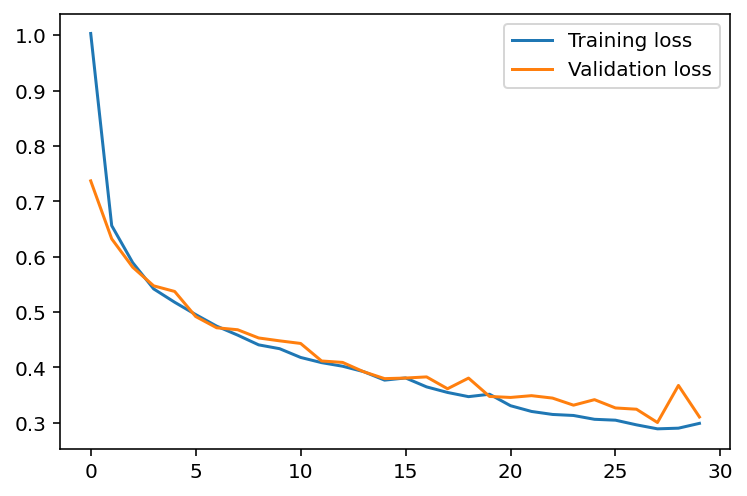

In [22]:
plt.figure()
plt.plot(np.arange(n_epochs), my_unet.loss_during_training, label='Training loss')
plt.plot(np.arange(n_epochs), my_unet.valid_loss_during_training, label='Validation loss')
plt.legend(loc='best')
plt.show()

Evaluate the performance of the model in the different data partitions.

In [23]:
def eval_performance(dataloader):
        
      loss = 0
      accuracy = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():

          for images,labels in dataloader:
              # Move input and label tensors to the default device
              images, labels = images.to(my_unet.device), labels.to(my_unet.device) 
              probs = my_unet.forward(images)

              labels_pred = torch.argmax(probs, dim=1)
              equals = (labels_pred == labels)
              accuracy += torch.mean(equals.type(torch.FloatTensor))
  
          return accuracy/len(dataloader)

In [24]:
train_acc = eval_performance(trainloader)
val_acc = eval_performance(validloader)
test_acc = eval_performance(testloader)
#val_acc = my_unet.eval_performance(validloader)
#test_acc = my_unet.eval_performance(testloader)

print('TRAIN ACC: ', train_acc)
print('VALIDATION ACC: ', val_acc)
print('TEST ACC: ', test_acc)

TRAIN ACC:  tensor(0.9000)
VALIDATION ACC:  tensor(0.8945)
TEST ACC:  tensor(0.8509)


Let's visualize a prediction.

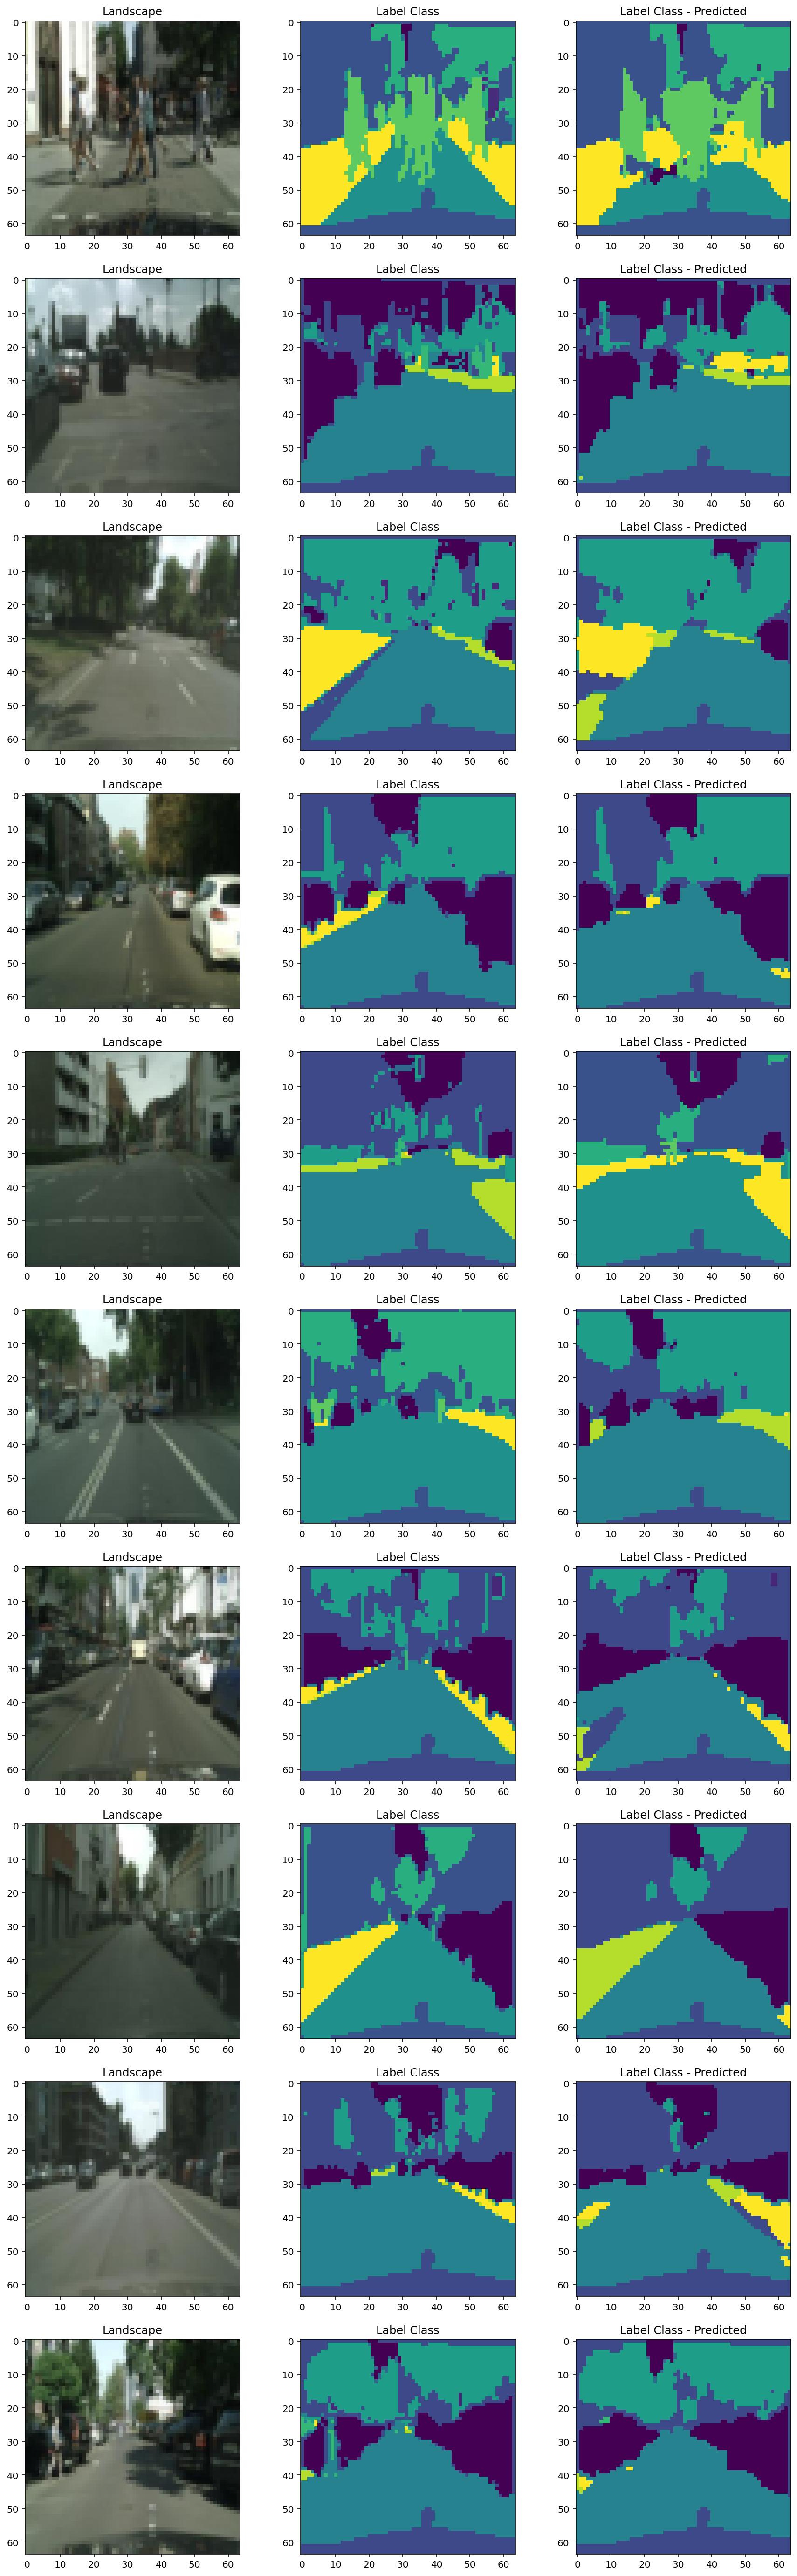

In [26]:
img, labels = next(iter(testloader))
img, labels = img.to(my_unet.device), labels.to(my_unet.device)

probs = my_unet.forward(img)

labels_pred = torch.argmax(probs.cpu().detach(), dim=1)

fig, axes = plt.subplots(10, 3, figsize=(3*5, 10*5))

for i in range(10):
    img_plot = np.transpose(img[i,:,:,:].cpu().detach().numpy(), (1, 2, 0))
    img_plot = img_plot / 2 + 0.5
    axes[i, 0].imshow(img_plot)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(labels[i,:,:].cpu().detach().numpy())
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(labels_pred[i,:,:].cpu().detach().numpy())
    axes[i, 2].set_title("Label Class - Predicted")
